In [ ]:
!pip install pandas-path

In [ ]:
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu113/torch_nightly.html -U

In [ ]:
!pip install pytorch-lightning segmentation-models-pytorch

In [ ]:
!pip install albumentations

Assumes you have already downloaded the training features, training labels, and external data to `../training_data`.

# General from Blog

In [ ]:
from pathlib import Path
from pandas_path import path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import random
import albumentations as A
import cv2
import torch
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import warnings

warnings.filterwarnings("ignore")

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1' # trains on 1 GPU, pick GPUID
os.chdir('../training_data/') # change to wherever train_features, train_labels, and *cvs live

In [10]:
DATA_PATH = Path.cwd().parent / "training_data"

In [11]:
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

In [12]:
flood_counts = train_metadata.groupby("flood_id")["chip_id"].nunique()
flood_counts.describe()

count    13.000000
mean     41.692308
std      19.947367
min      15.000000
25%      28.000000
50%      32.000000
75%      65.000000
max      69.000000
Name: chip_id, dtype: float64

In [13]:
location_counts = (
    train_metadata.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

Text(0.5, 1.0, 'Number of Chips by Location')

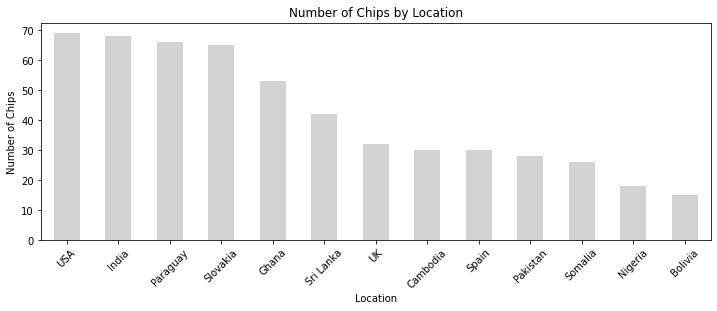

In [14]:
plt.figure(figsize=(12, 4))
location_counts.plot(kind="bar", color="lightgray")
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Chips by Location")

In [15]:
year = train_metadata.scene_start.dt.year
year_counts = train_metadata.groupby(year)["flood_id"].nunique()
year_counts

scene_start
2016    1
2017    2
2018    6
2019    3
2020    1
Name: flood_id, dtype: int64

In [16]:
train_metadata.groupby("flood_id")["scene_start"].nunique()

flood_id
awc    1
ayt    1
coz    1
hbe    1
hxu    1
jja    1
kuo    1
pxs    1
qus    1
qxb    1
tht    1
tnp    1
wvy    1
Name: scene_start, dtype: int64

In [17]:
train_metadata["feature_path"] = (
    DATA_PATH / "train_features" / train_metadata.image_id.path.with_suffix(".tif").path
)

In [18]:
train_metadata["label_path"] = (
    DATA_PATH / "train_labels" / train_metadata.chip_id.path.with_suffix(".tif").path
)

In [19]:
image_path = train_metadata.feature_path[0]
with rasterio.open(image_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)  

In [20]:
metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32720),
 'transform': Affine(10.0, 0.0, 314030.0,
        0.0, -10.0, 8585890.0)}

In [21]:
with rasterio.open(image_path) as img:
    gdal_mask = img.dataset_mask()

In [22]:
gdal_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

In [23]:
with rasterio.open(image_path) as img:
    numpy_mask = img.read(1, masked=True)

In [24]:
numpy_mask

masked_array(
  data=[[-16.20801544189453, -17.71950912475586, -16.281352996826172,
         ..., --, --, --],
        [-15.328896522521973, -18.231857299804688, -16.451892852783203,
         ..., --, --, --],
        [-15.353134155273438, -16.888309478759766, -15.585904121398926,
         ..., --, --, --],
        ...,
        [-15.74166202545166, -15.230668067932129, -13.455254554748535,
         ..., --, --, --],
        [-15.498257637023926, -14.100983619689941, -13.110269546508789,
         ..., --, --, --],
        [-16.05560302734375, -14.112099647521973, -14.76084041595459,
         ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=f

In [25]:
# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)


def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
    random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]
    chip_df = train_metadata[train_metadata.chip_id == "qus03"] #random_chip]

    # Extract paths to image files
    vv_path = chip_df[chip_df.polarization == "vv"].feature_path.values[0]
    vh_path = chip_df[chip_df.polarization == "vh"].feature_path.values[0]
    label_path = chip_df.label_path.values[0]

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()

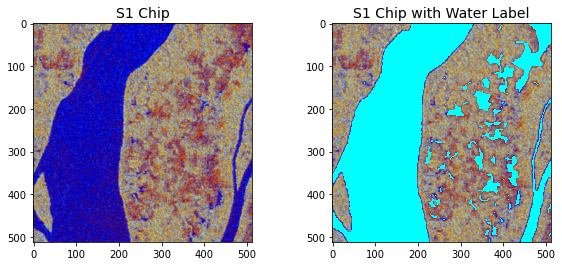

In [26]:
display_random_chip(7)

In [27]:
examples = [rasterio.open(train_metadata.feature_path[x]) for x in range(5)]
for image in examples:
    print(image.shape)

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)


In [28]:
# Helper function for pivoting out paths by chip
def get_paths_by_chip(image_level_df):
    """
    Returns a chip-level dataframe with pivoted columns
    for vv_path and vh_path.

    Args:
        image_level_df (pd.DataFrame): image-level dataframe

    Returns:
        chip_level_df (pd.DataFrame): chip-level dataframe
    """
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        paths.append([chip, vv_path, vh_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path"])

# used to calculate means & std for each of the chips and additional layers

In [29]:
names = ['_vh', '_vv', 'change', 'extent', 'occurrence', 'recurrence', 'seasonality', 'transitions', 'nasadem']

for n in names:
    layer = DATA_PATH.glob(f"**/*{n}.tif")
    ims = []
    for i in layer:
        ims.append(rasterio.open(i).read(1))
    print('layer: {}'.format(n))
    print('mean: {}'.format(np.mean(np.array(ims))))
    print('std: {}'.format(np.std(np.array(ims))))

layer: _vh
mean: -17.54796028137207
std: 5.6482720375061035
layer: _vv
mean: -10.775313377380371
std: 5.038407325744629
layer: change
mean: 236.96356944404405
std: 47.62208238871701
layer: extent
mean: 3.4183792170563305
std: 28.799238204080844
layer: occurrence
mean: 8.270102377747257
std: 34.480693749504006
layer: recurrence
mean: 12.422072491522645
std: 38.354506653571086
layer: seasonality
mean: 3.918482361684426
std: 28.87351299843209
layer: transitions
mean: 0.5896631853166981
std: 1.9514194857824236
layer: nasadem
mean: 151.06439787523334
std: 147.73737885200174


# Find difficult chips

In [30]:
class FloodDataset(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(self, x_paths, y_paths=None, transforms=None):
        self.data = x_paths
        self.label = y_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.data)
    
    def norm(self, arr, mn, mx):
        return (np.clip(arr, mn, mx) - mn) / (mx - mn)
    
    def std(self, arr, mean, std):
        return (arr - mean) / std

    def __getitem__(self, idx):
        # Loads a 2-channel image from a chip-level dataframe
        img = self.data.loc[idx]
        base_path = img.vv_path[:-6]
        with rasterio.open(img.vv_path) as vv:
            vv_img = vv.read(1)
        with rasterio.open(img.vh_path) as vh:
            vh_img = vh.read(1)

        with rasterio.open(base_path + 'nasadem.tif') as vh:
            elev = vh.read(1)
        with rasterio.open(base_path + 'jrc-gsw-extent.tif') as vh:
            extent = vh.read(1)
        with rasterio.open(base_path + 'jrc-gsw-occurrence.tif') as vh:
            occur = vh.read(1)
        with rasterio.open(base_path + 'jrc-gsw-recurrence.tif') as vh:
            recurr = vh.read(1)
        with rasterio.open(base_path + 'jrc-gsw-seasonality.tif') as vh:
            seas = vh.read(1)
        with rasterio.open(base_path + 'jrc-gsw-transitions.tif') as vh:
            trans = vh.read(1)
        with rasterio.open(base_path + 'jrc-gsw-change.tif') as vh:
            change = vh.read(1)
        
        # mean std standardization
        vh_mean = -17.547868728637695
        vh_std = 5.648269176483154
        vv_mean = -10.775313377380371
        vv_std = 5.038400650024414
        elev_mean = 151.06439787523334
        elev_std = 147.7373788520009
        extent_mean = 3.4183792170563305
        extent_std = 28.79923820408129
        occur_mean = 8.270102377747257
        occur_std = 34.48069374950159
        recurr_mean = 12.422072491522645
        recurr_std = 38.354506653571214
        seas_mean = 3.918482361684426
        seas_std = 28.87351299843167
        change_mean = 236.96356944404405
        change_std = 47.62208238871771
        trans_mean = 0.5896631853166981
        trans_std = 1.9514194857824525
        
        vv_img = self.std(vv_img, vv_mean, vv_std)
        vh_img = self.std(vh_img, vh_mean, vh_std)
        elev   = self.std(elev, elev_mean, elev_std)
        extent = self.std(extent, extent_mean, extent_std)
        occur  = self.std(occur, occur_mean, occur_std)
        recurr = self.std(recurr, recurr_mean, recurr_std)
        seas   = self.std(seas, seas_mean, seas_std)
        trans  = self.std(trans, trans_mean, trans_std)
        change = self.std(change, change_mean, change_std)
        
        # Prepare sample dictionary
        sample = {"chip_id": img.chip_id}
        x_arr = np.stack([
                            vv_img,
                            vh_img,
                            elev,
                            extent,
                            occur, 
                            recurr, 
                            seas, 
                            trans, 
                            change, 
                          ], axis=-1
                        ).astype(np.float32)

        # Apply data augmentations, if provided
        if self.transforms and self.label is not None:
            label_path = self.label.loc[idx].label_path
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1)
            aug = self.transforms(image=x_arr, mask=y_arr)
            x_arr, y_arr = aug['image'], aug['mask']
            sample["label"] = y_arr
        elif self.transforms and self.label is None:
            x_arr = self.transforms(image=x_arr)['image']
        
        x_arr = np.transpose(x_arr, [2, 0, 1])

        sample["chip"] = x_arr

        # Load label if available - training only
        if self.label is not None and self.transforms is None:
            label_path = self.label.loc[idx].label_path
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1)
            # Apply same data augmentations to label
            sample["label"] = y_arr

        return sample

In [31]:
# These transformations will be passed to our model class
original_height = original_width = 512
training_transformations = A.Compose(
    [
#         A.RandomCrop(256, 256),
#         A.ShiftScaleRotate(p=.9),
        A.OneOf([
            A.RandomSizedCrop(min_max_height=(int(0.5 * original_height),int(0.9 * original_height)), height=original_height, width=original_width, p=0.5),
            A.PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)
        ], p=1),
        A.Transpose(p=0.5),
        A.MaskDropout(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.8),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5, interpolation=cv2.INTER_NEAREST),
            A.GridDistortion(p=0.5, interpolation=cv2.INTER_NEAREST),
            A.RandomGridShuffle(p=0.5),
            A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1, interpolation=cv2.INTER_NEAREST)
            ], p=0.8),
        A.RandomBrightnessContrast(contrast_limit=0.1, brightness_by_max=False),
        A.Resize(256,256)
    ]
    
)

In [32]:
import torch.nn.functional as F

#PyTorch
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

class FocalTverskyLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.softmax(inputs, dim=1)[:, 1] #F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        valid_pixel_mask = targets.ne(255)
        inputs = inputs.masked_select(valid_pixel_mask)
        targets = targets.masked_select(valid_pixel_mask)
    
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [33]:
class XEDiceLoss(torch.nn.Module):
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """

    def __init__(self):
        super().__init__()
        self.xe = torch.nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255)  # valid pixel mask

        # Cross-entropy loss
        temp_true = torch.where((true == 255), 0, true)  # cast 255 to 0 temporarily
        xe_loss = self.xe(pred, temp_true)
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.sum(pred + true) + 1e-7)
        
        return (0.3 * xe_loss) + (0.7 * dice_loss)


In [34]:
def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255)  # valid pixel mask
    true = true.masked_select(valid_pixel_mask)
    pred = pred.masked_select(valid_pixel_mask)

    # Intersection and union totals
    intersection = np.logical_and(true.cpu(), pred.cpu())
    union = np.logical_or(true.cpu(), pred.cpu())
    return intersection.sum(), union.sum()


In [35]:
class FloodModel(pl.LightningModule):
    def __init__(self, hparams):
        super(FloodModel, self).__init__()
        self.hparams.update(hparams)
        # self.save_hyperparameters()
        self.backbone = self.hparams.get("backbone", "resnet34")
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.max_epochs = self.hparams.get("max_epochs", 1000)
        self.min_epochs = self.hparams.get("min_epochs", 6)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.x_train = self.hparams.get("x_train")
        self.y_train = self.hparams.get("y_train")
        self.x_val = self.hparams.get("x_val")
        self.y_val = self.hparams.get("y_val")
        self.output_path = self.hparams.get("output_path", "model-outputs")
        self.gpu = self.hparams.get("gpu", False)
        self.transform = training_transformations

        # Where final model will be saved
        self.output_path = Path.cwd() / self.output_path
        self.output_path.mkdir(exist_ok=True)

        # Track validation IOU globally (reset each epoch)
        self.intersection = 0
        self.union = 0

        # Instantiate datasets, model, and trainer params
        self.train_dataset = FloodDataset(
            self.x_train, self.y_train, transforms=self.transform
        )
        self.val_dataset = FloodDataset(self.x_val, self.y_val, transforms=None)
        self.model = self._prepare_model()
        self.trainer_params = self._get_trainer_params()

    ## Required LightningModule methods ##

    def forward(self, image):
        # Forward pass
        return self.model(image)

    def training_step(self, batch, batch_idx):
        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)
        with torch.cuda.amp.autocast():
            # Forward pass
            preds = self.forward(x)

            # Calculate training loss
            criterion = FocalTverskyLoss() #XEDiceLoss()
            xe_dice_loss = criterion(preds, y)

        # Log batch xe_dice_loss
        self.log(
            "xe_dice_loss",
            xe_dice_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return xe_dice_loss

    def validation_step(self, batch, batch_idx):
        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1

        # Calculate validation IOU (global)
        intersection, union = intersection_and_union(preds, y)
        self.intersection += intersection
        self.union += union

        # Log batch IOU
        batch_iou = intersection / union
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return batch_iou

    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        # Define optimizer
        optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.learning_rate)
#         optimizer =  torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
        # Define scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=self.patience
        )
        
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#             optimizer, T_0=30, T_mult=2, eta_min=5e-5, verbose=True
#         )

        
        scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "val_loss",
        }  # logged value to monitor
        return [optimizer], [scheduler]

    def validation_epoch_end(self, outputs):
        # Calculate IOU at end of epoch
        epoch_iou = self.intersection / self.union

        # Reset metrics before next epoch
        self.intersection = 0
        self.union = 0

        # Log epoch validation IOU
        self.log("val_loss", epoch_iou, on_epoch=True, prog_bar=True, logger=True)
        return epoch_iou

    ## Convenience Methods ##

    def _prepare_model(self):
        
        unet_model = smp.UnetPlusPlus(
            encoder_name=self.backbone,
            encoder_weights=self.weights,
#             encoder_depth=5,
#             decoder_channels=(512,256,128,64,32),
            decoder_attention_type='scse',
            in_channels=9,
            classes=2,
        )
        if self.gpu:
#             unet_model = torch.nn.DataParallel(unet_model)
            unet_model.cuda()
        return unet_model

    def _get_trainer_params(self):
        # Define callback behavior
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=self.output_path,
            monitor="val_loss",
            mode="max",
            verbose=True,
        )
        early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
            monitor="val_loss",
            patience=(self.patience * 3),
            mode="max",
            verbose=True,
        )

        # Specify where TensorBoard logs will be saved
        self.log_path = Path.cwd() / self.hparams.get("log_path", "tensorboard-logs")
        self.log_path.mkdir(exist_ok=True)
        logger = pl.loggers.TensorBoardLogger(self.log_path, name="benchmark-model")

        trainer_params = {
            "callbacks": [checkpoint_callback, early_stop_callback],
            "max_epochs": self.max_epochs,
            "min_epochs": self.min_epochs,
            "default_root_dir": self.output_path,
            "logger": logger,
            "gpus": None if not self.gpu else 1,
            "fast_dev_run": self.hparams.get("fast_dev_run", False),
            "num_sanity_val_steps": self.hparams.get("val_sanity_checks", 0),
        }
        return trainer_params

    def fit(self):
        # Set up and fit Trainer object
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)

    def predict(self, test_image):
        # Switch on evaluation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Set up test data
        test_dataset = FloodDataset(test_image, transforms=None)
        test_dataloader = torch.utils.data.DataLoader(test_dataset)

        # We expect a single input
        x = next(iter(test_dataloader))["chip"]
        if self.gpu:
            x = x.cuda(non_blocking=True)

        # Perform inference
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1
        return preds.detach().numpy().squeeze()


In [ ]:
# find difficult ids

from numpy.random import shuffle

random.seed(9)  # set a seed for reproducibility

flood_ids = train_metadata.flood_id.unique().tolist()

folds=len(flood_ids)

val_scores = []

name = 'unetpp-effb8-advprop-decay-rmsprop-9-augnoise-scse-val1-13f-std'

for f in range(folds):
    val_flood_ids = [flood_ids[f]]
    val = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
    train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

    # Separate features from labels
    val_x = get_paths_by_chip(val)
    val_y = val[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

    train_x = get_paths_by_chip(train)
    train_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

    hparams = {
        # Required hparams
        "x_train": train_x,
        "x_val": val_x,
        "y_train": train_y,
        "y_val": val_y,
        # Optional hparams
        "backbone": "timm-efficientnet-b8",
        "weights": 'advprop',
        "lr": 5e-4,
        "min_epochs": 6,
        "max_epochs": 1000,
        "patience": 6,
        "batch_size": 16, # may need to change
        "num_workers":8,
        "val_sanity_checks": 0,
        "fast_dev_run": False,
        "output_path": 'model-outputs-{}-cv{}'.format(name, f),
        "log_path": "tensorboard_logs",
        "gpu": torch.cuda.is_available(),
    }
    
    print('training fold {} of {}'.format(f+1, folds))
    flood_model = FloodModel(hparams=hparams)
    flood_model.fit()

    val_scores.append([val_flood_ids[0], flood_model.trainer_params["callbacks"][0].best_model_score.cpu()])

In [58]:
[i[0] for i in val_scores]

['awc',
 'ayt',
 'coz',
 'hbe',
 'hxu',
 'jja',
 'kuo',
 'pxs',
 'qus',
 'qxb',
 'tht',
 'tnp',
 'wvy']

In [60]:
pd.DataFrame([[i[0],i[1].item()] for i in val_scores]).sort_values(1)

,0,1
4,hxu,0.313182
5,jja,0.529775
7,pxs,0.587638
3,hbe,0.608235
6,kuo,0.612599
2,coz,0.668193
9,qxb,0.684958
0,awc,0.689921
11,tnp,0.713504
10,tht,0.738705


# keep difficult chips in training chunk during cv (hxu, jja, pxs)

In [ ]:
from numpy.random import shuffle

random.seed(9)  # set a seed for reproducibility

# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()

shuffle(flood_ids)
# val_flood_ids = random.sample(flood_ids, 2)
# val_flood_ids

folds=5
val_size = 2
val_scores = []

name = 'unetpp-effl2-noisystudent-decay-hxu-jja-pxs-rmsprop-9-augnoise-scse-val2-5f-std'
shuffle(flood_ids)
boost = ['hxu','jja','pxs']
flood_ids = list(set(flood_ids) - set(boost))
for f in range(folds):
    start = f*val_size
    val_flood_ids = flood_ids[start:start+val_size]
    val = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
    train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

    # Separate features from labels
    val_x = get_paths_by_chip(val)
    val_y = val[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

    train_x = get_paths_by_chip(train)
    train_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

    hparams = {
        # Required hparams
        "x_train": train_x,
        "x_val": val_x,
        "y_train": train_y,
        "y_val": val_y,
        # Optional hparams
        "backbone": "timm-efficientnet-l2",
        "weights": 'noisy-student',
        "lr": 5e-4,
        "min_epochs": 6,
        "max_epochs": 1000,
        "patience": 6,
        "batch_size": 8, # may need to change
        "num_workers":8,
        "val_sanity_checks": 0,
        "fast_dev_run": False,
        "output_path": 'model-outputs-{}-cv{}'.format(name, f),
        "log_path": "tensorboard_logs",
        "gpu": torch.cuda.is_available(),
    }
    
    submission_path = Path("{}".format(name))
    submission_path.mkdir(exist_ok=True)
    submission_assets_path = submission_path / "assets"
    submission_assets_path.mkdir(exist_ok=True)


    print('training fold {} of {}'.format(f, folds))
    flood_model = FloodModel(hparams=hparams)
    flood_model.fit()

    weight_path = submission_assets_path / 'flood_model-{}.pt'.format(f)
    torch.save(flood_model.state_dict(), weight_path)

    val_scores.append( flood_model.trainer_params["callbacks"][0].best_model_score)

In [72]:
scores = [s.cpu() for s in val_scores]

In [80]:
for f in range(folds):
    start = f*val_size
    val_flood_ids = flood_ids[start:start+val_size]
    print('fold: {} ids: {}'.format(f, val_flood_ids))

fold: 0 ids: ['coz', 'qus']
fold: 1 ids: ['tht', 'qxb']
fold: 2 ids: ['ayt', 'kuo']
fold: 3 ids: ['awc', 'tnp']
fold: 4 ids: ['hbe', 'wvy']


In [73]:
print('mean score: {} +/- {}'.format(np.mean(scores), np.std(scores)))

mean score: 0.7444243431091309 +/- 0.08064842224121094


# Prep for Submission

In [ ]:
%%file unetpp-effl2-noisystudent-decay-hxu-jja-pxs-rmsprop-9-augnoise-scse-val2-5f-std/flood_model.py
import numpy as np
import pytorch_lightning as pl
import rasterio
import segmentation_models_pytorch as smp
import torch

class FloodModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name='timm-efficientnet-l2',
            encoder_weights=None,
            decoder_attention_type='scse',
            in_channels=9,
            classes=2,
        ).cuda()

    def forward(self, image):
        # Forward pass
        return self.model(image)
    
    def norm(self, arr, mn, mx):
        return (np.clip(arr, mn, mx) - mn) / (mx - mn)

    def std(self, arr, mean, std):
        return ( arr - mean) / std

    def predict(self, vv_path, vh_path, change_path, extent_path, occur_path, recurr_path, seas_path, trans_path, nasadem_path):
        # Switch on evaluation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Create a 2-channel image
        with rasterio.open(vv_path) as vv:
            vv_img = vv.read(1)
        with rasterio.open(vh_path) as vh:
            vh_img = vh.read(1)

        with rasterio.open(nasadem_path) as vh:
            elev = vh.read(1)
        with rasterio.open(extent_path) as vh:
            extent = vh.read(1)
        with rasterio.open(occur_path) as vh:
            occur = vh.read(1)
        with rasterio.open(recurr_path) as vh:
            recurr = vh.read(1)
        with rasterio.open(seas_path) as vh:
            seas = vh.read(1)
        with rasterio.open(trans_path) as vh:
            trans = vh.read(1)
        with rasterio.open(change_path) as vh:
            change = vh.read(1)
        
        # mean std standardization
        vh_mean = -17.547868728637695
        vh_std = 5.648269176483154
        vv_mean = -10.775313377380371
        vv_std = 5.038400650024414
        elev_mean = 151.06439787523334
        elev_std = 147.7373788520009
        extent_mean = 3.4183792170563305
        extent_std = 28.79923820408129
        occur_mean = 8.270102377747257
        occur_std = 34.48069374950159
        recurr_mean = 12.422072491522645
        recurr_std = 38.354506653571214
        seas_mean = 3.918482361684426
        seas_std = 28.87351299843167
        change_mean = 236.96356944404405
        change_std = 47.62208238871771
        trans_mean = 0.5896631853166981
        trans_std = 1.9514194857824525
        
        vv_img = self.std(vv_img, vv_mean, vv_std)
        vh_img = self.std(vh_img, vh_mean, vh_std)
        elev   = self.std(elev, elev_mean, elev_std)
        extent = self.std(extent, extent_mean, extent_std)
        occur  = self.std(occur, occur_mean, occur_std)
        recurr = self.std(recurr, recurr_mean, recurr_std)
        seas   = self.std(seas, seas_mean, seas_std)
        trans  = self.std(trans, trans_mean, trans_std)
        change = self.std(change, change_mean, change_std)

        x_arr = np.stack([
                            vv_img,
                            vh_img,
                            elev,
                            extent,
                            occur, 
                            recurr, 
                            seas, 
                            trans, 
                            change, 
                          ], axis=-1
                        ).astype(np.float32)

        # Transpose
        x_arr = np.transpose(x_arr, [2, 0, 1])
        x_arr = np.expand_dims(x_arr, axis=0)

        # Perform inference
        x = torch.from_numpy(x_arr)
        x = x.cuda(non_blocking=True)

        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1
        return preds.detach().cpu().numpy().astype(np.uint8).squeeze().squeeze()

In [75]:
%%file unetpp-effl2-noisystudent-decay-hxu-jja-pxs-rmsprop-9-augnoise-scse-val2-5f-std/main.py
import os
from pathlib import Path

from loguru import logger
import numpy as np
from tifffile import imwrite
from tqdm import tqdm
import torch
import typer
import albumentations as A

from flood_model import FloodModel


ROOT_DIRECTORY = Path("/codeexecution")
SUBMISSION_DIRECTORY = ROOT_DIRECTORY / "submission"
ASSETS_DIRECTORY = ROOT_DIRECTORY / "assets"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"
INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / "test_features"
CHANGE  = DATA_DIRECTORY / "jrc_change"
EXTENT  = DATA_DIRECTORY / "jrc_extent"
OCCUR   = DATA_DIRECTORY / "jrc_occurrence"
RECURR  = DATA_DIRECTORY / "jrc_recurrence"
SEAS    = DATA_DIRECTORY / "jrc_seasonality"
TRANS   = DATA_DIRECTORY / "jrc_transitions"
NASADEM = DATA_DIRECTORY / "nasadem"

# Make sure the smp loader can find our torch assets because we don't have internet!
os.environ["TORCH_HOME"] = str(ASSETS_DIRECTORY / "torch")


def make_prediction(chip_id, model):
    """
    Given a chip_id, read in the vv/vh bands and predict a water mask.

    Args:
        chip_id (str): test chip id

    Returns:
        output_prediction (arr): prediction as a numpy array
    """
    logger.info("Starting inference.")
    try:
        output_prediction = None
        for e,m in enumerate(model):
            vv_path = INPUT_IMAGES_DIRECTORY / f"{chip_id}_vv.tif"
            vh_path = INPUT_IMAGES_DIRECTORY / f"{chip_id}_vh.tif"
            change_path  = CHANGE / f"{chip_id}.tif"
            extent_path  = EXTENT / f"{chip_id}.tif"
            occur_path   = OCCUR / f"{chip_id}.tif"
            recurr_path  = RECURR / f"{chip_id}.tif"
            seas_path    = SEAS / f"{chip_id}.tif"
            trans_path   = TRANS / f"{chip_id}.tif"
            nasadem_path = NASADEM / f"{chip_id}.tif"
            if e == 0:
                output_prediction = m.predict(vv_path, vh_path, change_path, extent_path, occur_path, recurr_path, seas_path, trans_path, nasadem_path)
            else:
                output_prediction += m.predict(vv_path, vh_path, change_path, extent_path, occur_path, recurr_path, seas_path, trans_path, nasadem_path)
                
    except Exception as e:
        logger.error(f"No bands found for {chip_id}. {e}")
        raise
    return output_prediction


def get_expected_chip_ids():
    """
    Use the test features directory to see which images are expected.
    """
    paths = INPUT_IMAGES_DIRECTORY.glob("*.tif")
    # Return one chip id per two bands (VV/VH)
    ids = list(sorted(set(path.stem.split("_")[0] for path in paths)))
    return ids


def main():
    """
    For each set of two input bands, generate an output file
    using the `make_predictions` function.
    """
    logger.info("Loading model")
    # Explicitly set where we expect smp to load the saved resnet from just to be sure
    torch.hub.set_dir(ASSETS_DIRECTORY / "torch/hub")
    folds = 5
    models = []
    for i in range(folds):
        model = FloodModel()
        model.load_state_dict(torch.load(ASSETS_DIRECTORY / "flood_model-{}.pt".format(i)))
        models.append(model.cuda())

    logger.info("Finding chip IDs")
    chip_ids = get_expected_chip_ids()
    if not chip_ids:
        typer.echo("No input images found!")
        raise typer.Exit(code=1)

    logger.info(f"Found {len(chip_ids)} test chip_ids. Generating predictions.")
    for chip_id in tqdm(chip_ids, miniters=25):
        output_path = SUBMISSION_DIRECTORY / f"{chip_id}.tif"
        output_data = make_prediction(chip_id, models).astype(np.uint8)
        imwrite(output_path, ((output_data > 2) * 1).astype(np.uint8), dtype=np.uint8)

    logger.success(f"Inference complete.")

if __name__ == "__main__":
    typer.run(main)

Writing unetpp-effl2-noisystudent-decay-hxu-jja-pxs-rmsprop-9-augnoise-scse-val2-5f-std/main.py


In [ ]:
!cp -R ~/.cache/torch/ unetpp-effl2-noisystudent-decay-hxu-jja-pxs-rmsprop-9-augnoise-scse-val2-5f-std/assets/